https://doc.sagemath.org/html/en/reference/rings_numerical/sage/rings/real_mpfi.html

https://doc.sagemath.org/html/en/reference/spkg/mpfi.html#spkg-mpfi

https://doc.sagemath.org/html/en/reference/spkg/mpfr.html#spkg-mpfr

In [43]:
prec = 200
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)

I = RIF(-1,1)
J=RBF(-1,1)


def f1(x):
    return exp(x)

f2=exp(x)

f3 = fast_callable(f2,vars=[x],domain=RIF)

g=f3

print(g(I).upper())
print(g(I).lower())
print("")
print(g(J).upper())
print(g(J).lower())

2.7182818284590452353602874713526624977572470936999595749670
0.36787944117144232159552377016146086744581113103176783450783

1.0000000018626451509656805083038651841752235229184026047820
0.13533528298453108328829450279734718265936030551117923941952


In [ ]:
def smooth_fast_callable_rif(f, x, zero_value=RealIntervalField()(0)):
    RIF = RealIntervalField()
    f_fast = fast_callable(f, vars=[x], domain=RIF)
    prec = RIF.prec()

    def f_modified(interval):
        interval = RIF(interval)

        # Si l'intervalle est contenu dans une petite bande autour de 0
        if interval.abs() <= 2**(-prec):
            return RIF(zero_value)

        # Si 0 est inclus dans un intervalle plus large, on découpe l'intervalle
        if interval.contains_zero():
            a, b = interval.endpoints()
            mid = RIF((a + b)/2)
            left = f_modified(RIF(a, mid))
            right = f_modified(RIF(mid, b))
            return left.union(right)

        # Sinon, on peut simplement évaluer
        return f_fast(interval)

    return f_modified


1.?


In [56]:
RIF = RealIntervalField(100)
x = var('x')
f = x + 1
I = RIF(-10, 2)
print(RIF(f(x=I)).str(style='brackets'))
print(RIF(f(x=f(x=I))).str(style='brackets'))


[-9.0000000000000000000000000000000 .. 3.0000000000000000000000000000000]
[-8.0000000000000000000000000000000 .. 4.0000000000000000000000000000000]


{'xmin': -4.0, 'xmax': 2.0, 'ymin': -0.9999942254823972, 'ymax': 0.5061192578887295}


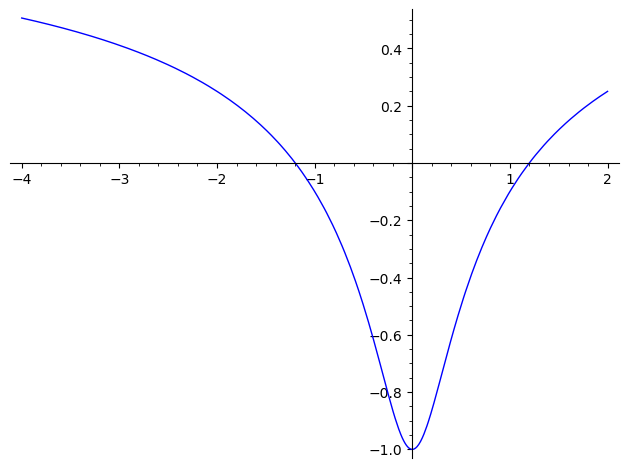

In [8]:
var('x y')

W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime

P= plot(a, (x, -4, 2))
print(P.get_minmax_data())
P.show()

In [44]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import time
import numpy as np
prec = 300
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[a_derivs[0].taylor(x,0)]
b_derivs = [b]
b_derivs_0=[b_derivs[0].taylor(x,0)]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(a_derivs[k].taylor(x,0))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(b_derivs[k].taylor(x,0))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec) else f_fast(ball) # Set the sensibility to be equal to the field precision
    return f_modified

# Convert symbolic functions to numerical ones evaluable on RealBallField elements
a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(5)]

phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)


def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))


M_funcs=[M_0_func,M_1_func,M_2_func]


In [33]:
f= M_2_func
Ix=RIF([-2,2])
Iy=RIF([-2,2])
print(f(Ix,Iy).upper())
print(f(Ix,Iy).lower())
print(RIF(f(Ix,Iy)).upper()-RIF(f(Ix,Iy)).lower())


94101.0530714740468782929528383564489926924672881330595951989264335172600810863125293784267
94101.0530714740468782929528383564489926924672881330595951989264335172600810863125293784258
7.72133638420204337720842826020753345291256937185193424077961159065537911936261688885525540e-85


In [3]:
def maximum_interval(f, a, b, prec=100):
    """
    Calcule une majoration du maximum absolu de f sur l'intervalle [a, b]
    en utilisant l'arithmétique des intervalles (RealIntervalField).
    
    Paramètres :
    - f : une fonction Sage avec une variable nommée x
    - a, b : bornes réelles de l'intervalle [a, b]
    - prec : précision (en bits) de l'arithmétique des intervalles

    Retour :
    - Une borne supérieure de |f(x)| sur [a, b]
    """
    RIF = RealIntervalField(prec)
    x = var('x')
    I = RIF(a, b)
    
    fxI = f(x=I)
    upper = abs(RIF(fxI)).upper()
    lower = abs(RIF(fxI)).lower()
    
    return max(upper, lower)

x = var('x')
f = lambda x: sin(x) + x^2
maximum_interval(phi_1, 2, 3)

NaN